### QUESTION 4: 

Design a regression model using any features from the papers you find or other new features you may find useful for this problem. Fit your model on the data of each hashtag and report fitting MSE and significance of features.

#### Ans:

We will consider below features:

* Average impressions = total impressions / total tweets (for a particular hour)
* Average ranking score = total ranking / total tweets (for a particular hour)
* Average User Passivity(for original user) = total passivity / total tweets (for a particular hour)

In [1]:
hash_tags = ['#gohawks','#gopatriots','#nfl','#patriots','#sb49','#superbowl']

In [2]:
import pickle

def save_object(data, fileName):
    with open('pynb_data/'+fileName + ".pickle", 'wb') as f:
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
        
def load_object(fileName):
    try:
        with open('pynb_data/'+fileName + ".pickle", 'rb') as f:
            data = pickle.load(f)
            return data
    except IOError:
        print("Could not read file: " + fileName)

In [3]:
from datetime import date, timedelta
import datetime
import pytz
import json

def getHour(timestamp):
    d = datetime.datetime.fromtimestamp(timestamp)
    return d.hour

def getHourAsKey(timestamp):
    d = datetime.datetime.fromtimestamp(timestamp)
    return "{}:{}:{}:{}".format(d.year,d.month,d.day,d.hour)

def getDayAsKey(timestamp):
    d = datetime.datetime.fromtimestamp(timestamp)
    return "{}:{}:{}".format(d.year,d.month,d.day)

#https://stackoverflow.com/questions/2315032/how-do-i-find-missing-dates-in-a-list-of-sorted-dates
def getAllDays(dayStrList):
    dayList = [ datetime.datetime.strptime(x, '%Y:%m:%d') for x in dayStrList ]    
    irange = [i for i in range((dayList[-1] - dayList[0]).days)]
    irange.append(irange[-1]+1)    
    allDaysList = sorted(list(set(dayList[0] + timedelta(x) for x in irange)))
    allDayStrList = [ ('{}:{}:{}'.format(d.year,d.month,d.day)) for d in allDaysList ]
    return allDayStrList

# https://arxiv.org/pdf/1401.2018v2.pdf
def getUserPassivity(user,ts):
    createdDateTimeObj = datetime.datetime.strptime(user['created_at'],"%a %b %d %H:%M:%S %z %Y")
    created = datetime.datetime.fromtimestamp(createdDateTimeObj.timestamp())
    d = datetime.datetime.fromtimestamp(ts)
    td = (created - d).days
    statuses_count = user['statuses_count']
    return td/(1.0+statuses_count)
    
def getFeatures(hash_tag):
    hourToTweets = {}
    hourToRetweets = {}
    hourToFollowerCount = {}
    hourToMaxFollowers = {}
    hourToUserPassivitySum = {}
    hourToRankingMetricSum = {}
    hourToImpressionsMetricSum = {}
    dayDict = {}
    features = []
    labels = []
    
    filename = 'data/tweets_'+tag+'.txt'
    with open(filename) as f:
        for line in f:
            json_object = json.loads(line)
            timestamp = json_object['citation_date']
            dayDict[getDayAsKey(timestamp)]=1        
            key = getHourAsKey(timestamp)
            
            if key not in hourToUserPassivitySum.keys():
                hourToUserPassivitySum[key]=0.0
            hourToUserPassivitySum[key]+=getUserPassivity(json_object['tweet']['user'],timestamp)
            
            if key not in hourToRankingMetricSum.keys():
                hourToRankingMetricSum[key]=0.0
            hourToRankingMetricSum[key]+=json_object['metrics']['ranking_score']
            
            if key not in hourToImpressionsMetricSum.keys():
                hourToImpressionsMetricSum[key]=0.0
            hourToImpressionsMetricSum[key]+=json_object['metrics']['impressions']
            
            if key not in hourToTweets.keys():
                hourToTweets[key]=0
            hourToTweets[key]+=1
            
            retweetCount = json_object['metrics']['citations']['total']        
            
            if key not in hourToRetweets.keys():
                hourToRetweets[key]=0
            hourToRetweets[key]+=retweetCount
        
            followerCount = json_object['author']['followers']
            if key not in hourToFollowerCount.keys():
                hourToFollowerCount[key]=0
            hourToFollowerCount[key]+=followerCount
        
            if key not in hourToMaxFollowers.keys():
                hourToMaxFollowers[key]=0
            hourToMaxFollowers[key] = max(hourToMaxFollowers[key],followerCount)
            
        dayList = getAllDays(list(dayDict.keys()))
#         print(dayList)
            
        for day in dayList:
            for h in range(0,24):
                key=day+':'+str(h)
                tweetCount = hourToTweets.get(key, 0)
                retweetCount = hourToRetweets.get(key,0)
                followerCount = hourToFollowerCount.get(key,0)
                maxFollowers = hourToMaxFollowers.get(key,0)
                if tweetCount > 0:
                    avgRanking = hourToRankingMetricSum.get(key,0)/tweetCount
                    avgImpressions = hourToImpressionsMetricSum.get(key,0)/tweetCount
                    avgUserPassivity = hourToUserPassivitySum.get(key,0)/tweetCount                
                else:
                    avgRanking = 0
                    avgImpressions = 0
                    avgUserPassivity = 0

                feature = [tweetCount, retweetCount, followerCount, maxFollowers, avgRanking,avgImpressions,avgUserPassivity, h]
                features.append(feature)
                
                nexthour = datetime.datetime.strptime(key, '%Y:%m:%d:%H') + timedelta(hours=1)
                nexthourkey = "{}:{}:{}:{}".format(nexthour.year,nexthour.month,nexthour.day,nexthour.hour)
                labels.append(hourToTweets.get(nexthourkey,0))
                
    return features,labels

In [8]:
for tag in hash_tags:
    print("Started building feature vectors for {}".format(tag))
    features,labels = getFeatures(tag)
    save_object(features,'q4features_{}'.format(tag))
    save_object(labels,'q4labels_{}'.format(tag))
    print("Finished building feature vectors for {}".format(tag))

Started building feature vectors for #gohawks
Finished building feature vectors for #gohawks
Started building feature vectors for #gopatriots
Finished building feature vectors for #gopatriots
Started building feature vectors for #nfl
Finished building feature vectors for #nfl
Started building feature vectors for #patriots
Finished building feature vectors for #patriots
Started building feature vectors for #sb49
Finished building feature vectors for #sb49
Started building feature vectors for #superbowl
Finished building feature vectors for #superbowl


In [6]:
import statsmodels.api as sm
import statsmodels.tools.eval_measures as ste

for tag in hash_tags:
    print('\nLinear Regression Model for {}'.format(tag))
    X = load_object('q4features_{}'.format(tag))
    y = load_object('q4labels_{}'.format(tag))
    
#     https://becominghuman.ai/stats-models-vs-sklearn-for-linear-regression-f19df95ad99b
    X = sm.add_constant(X)
    
    model = sm.OLS(y,X)
    results = model.fit()
    pred_y = results.predict(X)
    print("\nMSE : {}".format(ste.mse(pred_y, y,axis=0)))
    print("R-squared : {}".format(results.rsquared))    
    print("P values for the features are \n {} \n\n".format(results.pvalues))
    print(results.summary())
    print('---'*20)
    print('\n\n')
    


Linear Regression Model for #gohawks

MSE : 825068.0463121694
R-squared : 0.47918645978420327
P values for the features are 
 [8.49085912e-01 2.48474038e-13 2.32296614e-03 1.94186167e-02
 9.03971515e-01 4.76450527e-01 2.88020696e-01 8.50946571e-01
 7.63431096e-01] 


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     59.69
Date:                Sat, 16 Mar 2019   Prob (F-statistic):           1.00e-68
Time:                        16:18:47   Log-Likelihood:                -4345.7
No. Observations:                 528   AIC:                             8709.
Df Residuals:                     519   BIC:                             8748.
Df Model:                           8                                         
Covariance Type:    

### QUESTION 5: 
For each of the top 3 features (i.e. with the smallest p-values) in your mea- surements, draw a scatter plot of predictant (number of tweets for next hour) versus value of that feature, using all the samples you have extracted, and analyze it.
Do the regression coefficients agree with the trends in the plots? If not, why?


Most important features(lowest p-values) for #gohawks
 followerCount
 retweetCount
 tweetCount
Pvalue for feature followerCount for #gohawks is 0.019418616697516218
Coefficient for feature followerCount for #gohawks is -0.00020031409409211116


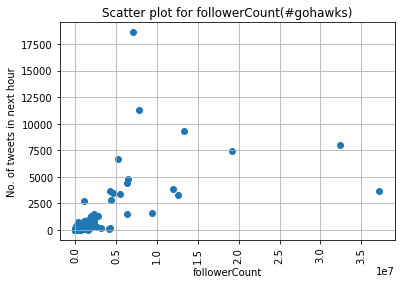

Pvalue for feature retweetCount for #gohawks is 0.0023229661375244355
Coefficient for feature retweetCount for #gohawks is -0.1427519800240456


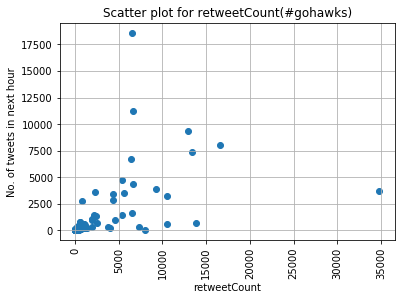

Pvalue for feature tweetCount for #gohawks is 2.484740380197345e-13
Coefficient for feature tweetCount for #gohawks is 1.3231081146032913


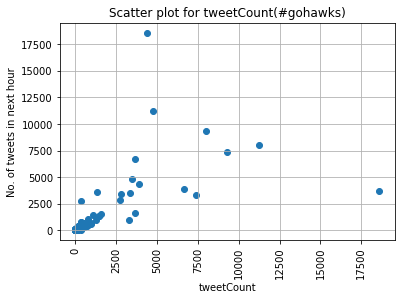

------------------------------------------------------------




Most important features(lowest p-values) for #gopatriots
 tweetCount
 retweetCount
 avgRanking
Pvalue for feature tweetCount for #gopatriots is 0.27743124776508066
Coefficient for feature tweetCount for #gopatriots is 0.3100637916510618


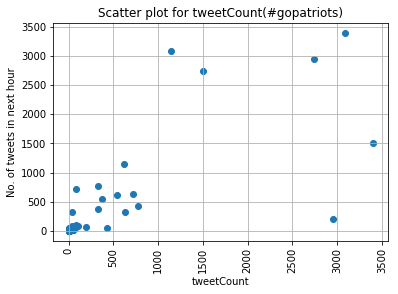

Pvalue for feature retweetCount for #gopatriots is 0.012368461055716292
Coefficient for feature retweetCount for #gopatriots is 0.4819806313498698


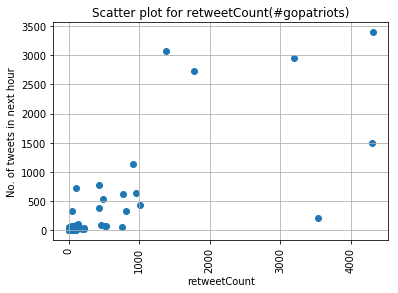

Pvalue for feature avgRanking for #gopatriots is 0.5641225038612001
Coefficient for feature avgRanking for #gopatriots is 2.1221482190083245


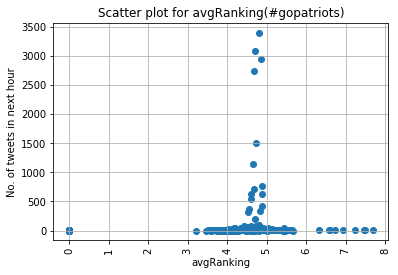

------------------------------------------------------------




Most important features(lowest p-values) for #nfl
 followerCount
 tweetCount
 maxFollowers
Pvalue for feature followerCount for #nfl is 1.2255460818393185e-05
Coefficient for feature followerCount for #nfl is 0.00011912091635408147


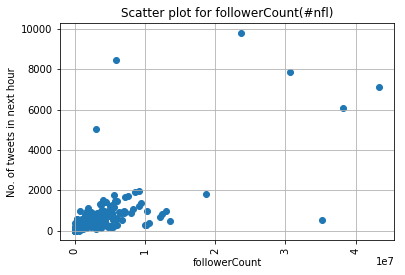

Pvalue for feature tweetCount for #nfl is 0.0002354189353630744
Coefficient for feature tweetCount for #nfl is 0.5433642414988628


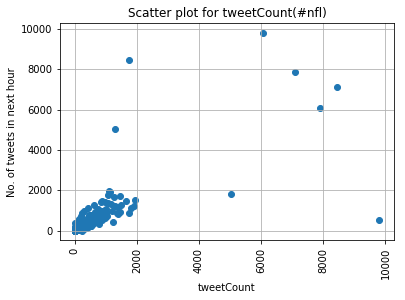

Pvalue for feature maxFollowers for #nfl is 0.003068777762117389
Coefficient for feature maxFollowers for #nfl is -0.00012127792570232783


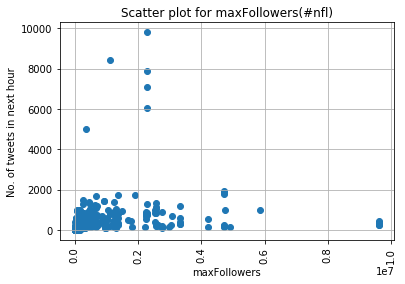

------------------------------------------------------------




Most important features(lowest p-values) for #patriots
 maxFollowers
 tweetCount
 avgImpressions
Pvalue for feature maxFollowers for #patriots is 0.06317116795144974
Coefficient for feature maxFollowers for #patriots is 0.00020204738456655477


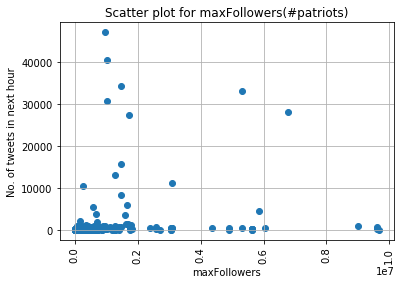

Pvalue for feature tweetCount for #patriots is 1.4907682636932697e-34
Coefficient for feature tweetCount for #patriots is 0.9168458290264504


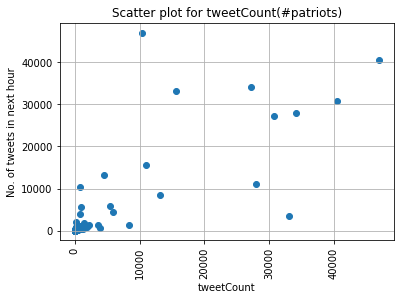

Pvalue for feature avgImpressions for #patriots is 0.19577609846332789
Coefficient for feature avgImpressions for #patriots is -0.010629420449420064


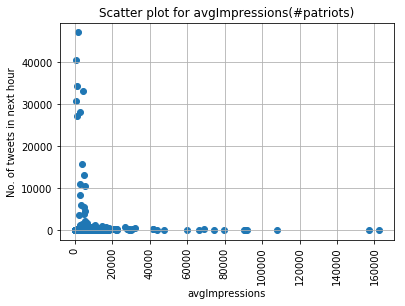

------------------------------------------------------------




Most important features(lowest p-values) for #sb49
 maxFollowers
 tweetCount
 retweetCount
Pvalue for feature maxFollowers for #sb49 is 0.011374869154617388
Coefficient for feature maxFollowers for #sb49 is 0.00012085277315449273


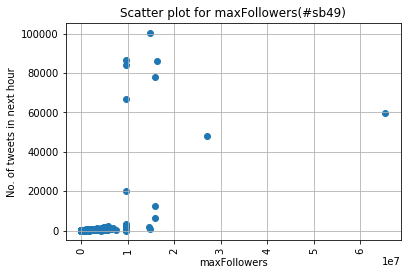

Pvalue for feature tweetCount for #sb49 is 2.7654412117414616e-35
Coefficient for feature tweetCount for #sb49 is 1.1413784114890606


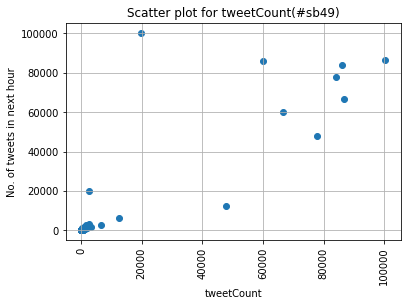

Pvalue for feature retweetCount for #sb49 is 0.027192037522002836
Coefficient for feature retweetCount for #sb49 is -0.17312421600205374


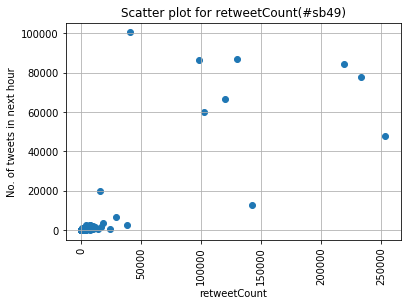

------------------------------------------------------------




Most important features(lowest p-values) for #superbowl
 tweetCount
 followerCount
 retweetCount
Pvalue for feature tweetCount for #superbowl is 4.2136375683091235e-105
Coefficient for feature tweetCount for #superbowl is 2.271543668912925


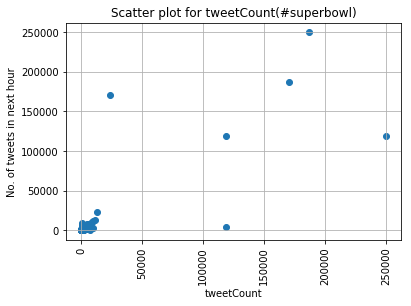

Pvalue for feature followerCount for #superbowl is 9.48501435746832e-10
Coefficient for feature followerCount for #superbowl is -0.00014339923665885568


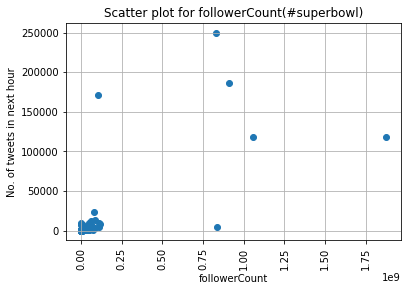

Pvalue for feature retweetCount for #superbowl is 5.597368677317849e-07
Coefficient for feature retweetCount for #superbowl is -0.24294234467145162


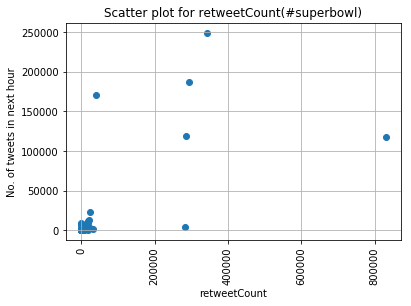

------------------------------------------------------------





In [27]:
import numpy as np
import matplotlib.pyplot as plt

index_to_feature = ['bias','tweetCount', 'retweetCount', 'followerCount', 'maxFollowers', 'avgRanking','avgImpressions','avgUserPassivity','hr']

def plotScatter(features,labels,index,tag):
    if index==0:
        return
    
    x = [f[index-1] for f in features]
    y = labels
    plt.scatter(x, y)
    plt.xlabel(index_to_feature[index])
    plt.xticks(rotation=90)
    plt.ylabel("No. of tweets in next hour")
    plt.title("Scatter plot for "+index_to_feature[index]+"("+tag+")")
    plt.grid()
    plt.show()

for tag in hash_tags:
    X_orig = load_object('q4features_{}'.format(tag))
    y = load_object('q4labels_{}'.format(tag))
    X = sm.add_constant(X_orig)

    model = sm.OLS(y,X)
    results = model.fit()
    a = np.array(results.pvalues)
#     print(results.params)
    
    ind = np.argpartition(a, 3)
    indices = ind[:3]

    print('\nMost important features(lowest p-values) for {}'.format(tag))
    for i in indices:    
        print(' '+index_to_feature[i])
        
    for i in indices:
        print("Pvalue for feature {} for {} is {}".format(index_to_feature[i],tag,results.pvalues[i]))
        print("Coefficient for feature {} for {} is {}".format(index_to_feature[i],tag,results.params[i]))
        plotScatter(X_orig,y,i,tag)
    
    print('---'*20)
    print('\n\n')
